#Практическое задание к курсу

__1.   Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.__   
    

*   *вариант для 1) Обучите VAE на fashion_mnist 
*   *вариант для 1) Обучите GAN на одном классе CIFAR
*   *вариант для 1) обучите классификатор на данных tfds (Kaggle, UCI)
*   *вариант для 1) обучите семантическую сегментацию на tfds (Kaggle, UCI)

   


In [34]:
# Импорт необходимых библиотек
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
# Строим слой семплирования sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [36]:
# Строим энкодер encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

In [37]:
# Строим свой decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        289 

In [38]:
# Создаем класс модель по Model с особым шагом обучения train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [39]:
# Извлечение данных и их предобработка
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_f = np.concatenate([x_train, x_test], axis=0)
mnist_f = np.expand_dims(mnist_f, -1).astype("float32") / 255

In [40]:
# Учим VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_f, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 6s 9ms/step - loss: 327.3650 - reconstruction_loss: 322.7833 - kl_loss: 4.5818
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 271.9248 - reconstruction_loss: 268.3261 - kl_loss: 3.5987
Epoch 3/10
547/547 [==============================] - 5s 9ms/step - loss: 267.2326 - reconstruction_loss: 263.7122 - kl_loss: 3.5205
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 265.0660 - reconstruction_loss: 261.5537 - kl_loss: 3.5123
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 263.7314 - reconstruction_loss: 260.2232 - kl_loss: 3.5083
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 263.0673 - reconstruction_loss: 259.5517 - kl_loss: 3.5156
Epoch 7/10
547/547 [==============================] - 5s 9ms/step - loss: 262.1765 - reconstruction_loss: 258.6533 - kl_loss: 3.5233
Epoch 8/10
547/547 [==============================] - 5s 9ms/step - l

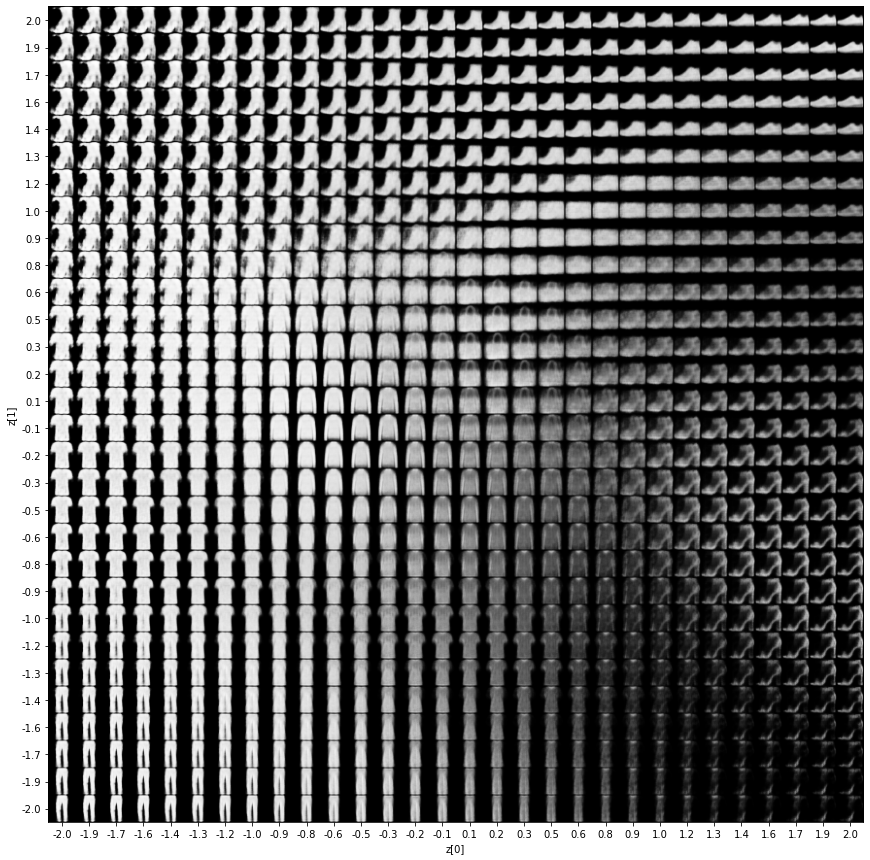

In [41]:
# Результат предсказания
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of fations
    n = 30
    f_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((f_size * n, f_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of fation classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            fation = x_decoded[0].reshape(f_size, f_size)
            figure[
                i * f_size : (i + 1) * f_size,
                j * f_size : (j + 1) * f_size,
            ] = fation

    plt.figure(figsize=(figsize, figsize))
    start_range = f_size // 2
    end_range = n * f_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, f_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

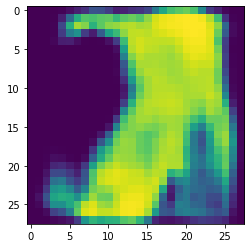

In [42]:
x_decoded = decoder.predict([[-1.990,1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

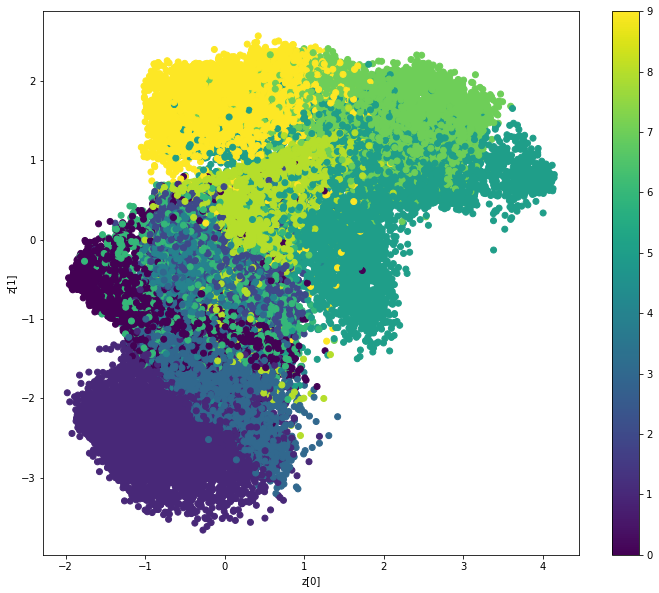

In [43]:
# Посмотрим на кластеры в скрытом пространстве
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the fation classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

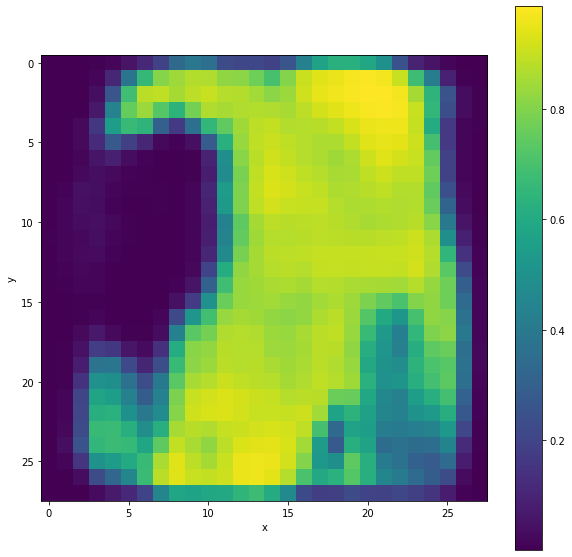

In [44]:
# Построим пример генерации
def plot_digit_from_decoder(decoder, z, f_size):
    # display a 2D plot of the fation classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    fation = decoder.predict(data)
    fation = fation.reshape(f_size, f_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(fation)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-1.5,1.], 28)

In [45]:
# Учим еще 50 эпох
vae.fit(mnist_f, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 5s 9ms/step - loss: 260.5222 - reconstruction_loss: 256.9672 - kl_loss: 3.5550
Epoch 2/50
547/547 [==============================] - 5s 9ms/step - loss: 260.1479 - reconstruction_loss: 256.5778 - kl_loss: 3.5701
Epoch 3/50
547/547 [==============================] - 5s 9ms/step - loss: 259.9455 - reconstruction_loss: 256.3747 - kl_loss: 3.5708
Epoch 4/50
547/547 [==============================] - 5s 9ms/step - loss: 259.5856 - reconstruction_loss: 255.9992 - kl_loss: 3.5864
Epoch 5/50
547/547 [==============================] - 5s 9ms/step - loss: 259.2445 - reconstruction_loss: 255.6576 - kl_loss: 3.5869
Epoch 6/50
547/547 [==============================] - 5s 9ms/step - loss: 259.1182 - reconstruction_loss: 255.5167 - kl_loss: 3.6015
Epoch 7/50
547/547 [==============================] - 5s 9ms/step - loss: 258.9332 - reconstruction_loss: 255.3223 - kl_loss: 3.6109
Epoch 8/50
547/547 [==============================] - 5s 9ms/step - l

__Вывод:__

Показатель "loss" значительно упал, т.е модель стала заметно точнее.

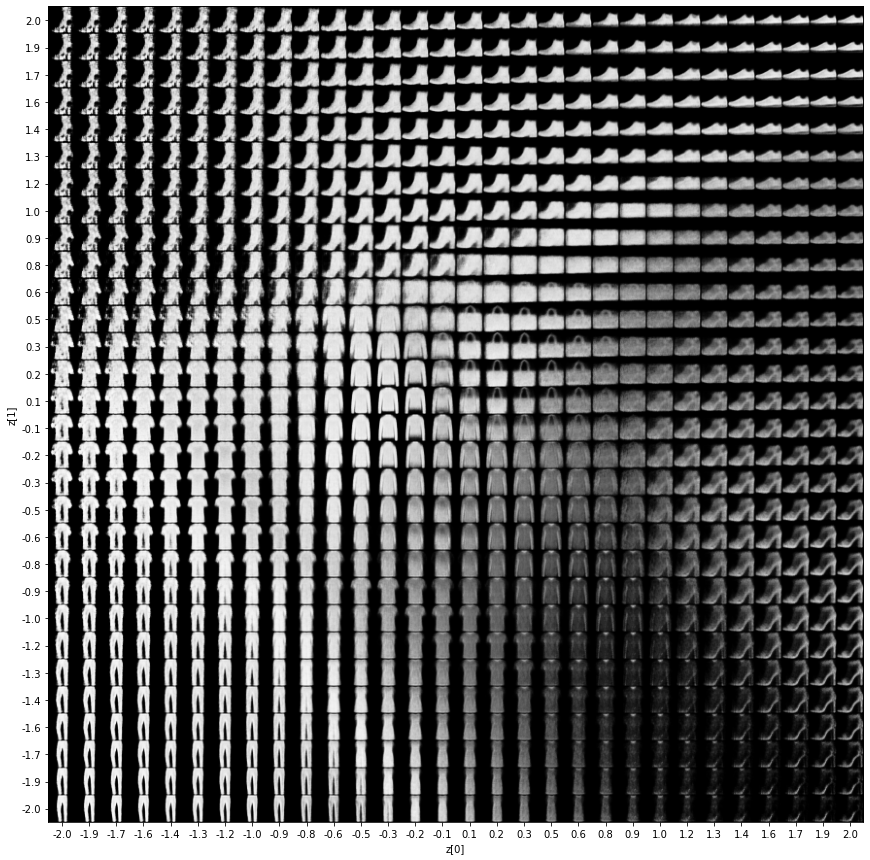

In [46]:
# Результат предсказания
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of fations
    n = 30
    f_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((f_size * n, f_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of fation classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            fation = x_decoded[0].reshape(f_size, f_size)
            figure[
                i * f_size : (i + 1) * f_size,
                j * f_size : (j + 1) * f_size,
            ] = fation

    plt.figure(figsize=(figsize, figsize))
    start_range = f_size // 2
    end_range = n * f_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, f_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

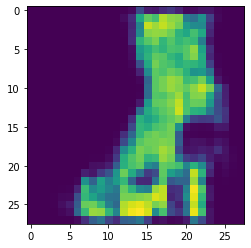

In [47]:
x_decoded = decoder.predict([[-1.990,1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

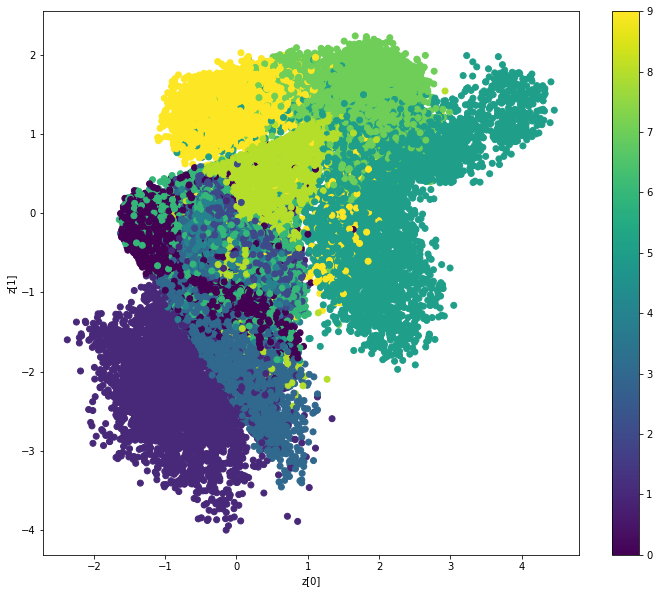

In [48]:
# Посмотрим на кластеры в скрытом пространстве
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the fation classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

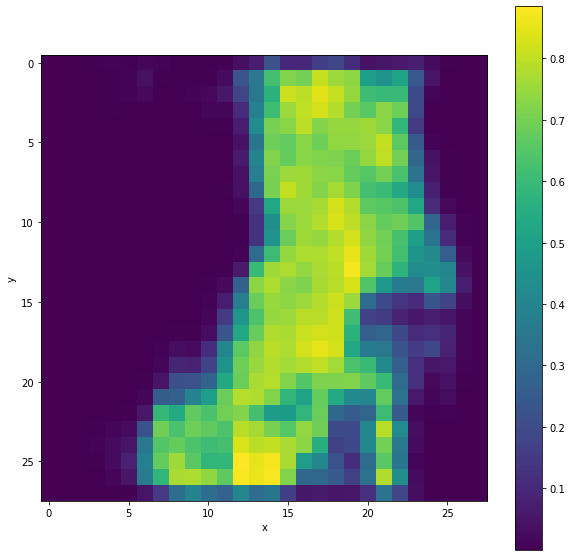

In [49]:
# Построим пример генерации
def plot_digit_from_decoder(decoder, z, f_size):
    # display a 2D plot of the fation classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    fation = decoder.predict(data)
    fation = fation.reshape(f_size, f_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(fation)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-1.5,1.], 28)

In [50]:
# Учим еще 50 эпох, уменьшив "batch_size" в два раза 
vae.fit(mnist_f, epochs=50, batch_size=64)

Epoch 1/50
1094/1094 [==============================] - 7s 6ms/step - loss: 255.6664 - reconstruction_loss: 251.8579 - kl_loss: 3.8084
Epoch 2/50
1094/1094 [==============================] - 7s 6ms/step - loss: 255.1590 - reconstruction_loss: 251.3468 - kl_loss: 3.8122
Epoch 3/50
1094/1094 [==============================] - 7s 6ms/step - loss: 255.2752 - reconstruction_loss: 251.4685 - kl_loss: 3.8067
Epoch 4/50
1094/1094 [==============================] - 7s 6ms/step - loss: 254.9057 - reconstruction_loss: 251.0789 - kl_loss: 3.8268
Epoch 5/50
1094/1094 [==============================] - 7s 6ms/step - loss: 254.9942 - reconstruction_loss: 251.1700 - kl_loss: 3.8241
Epoch 6/50
1094/1094 [==============================] - 7s 6ms/step - loss: 254.7684 - reconstruction_loss: 250.9589 - kl_loss: 3.8095
Epoch 7/50
1094/1094 [==============================] - 7s 6ms/step - loss: 254.8844 - reconstruction_loss: 251.0607 - kl_loss: 3.8237
Epoch 8/50
1094/1094 [==============================] -

__Вывод:__

Показатель "loss" продолжил падение, но уже значитель в меньшей степени. Следовательно, точность модели повысилась незначительно.


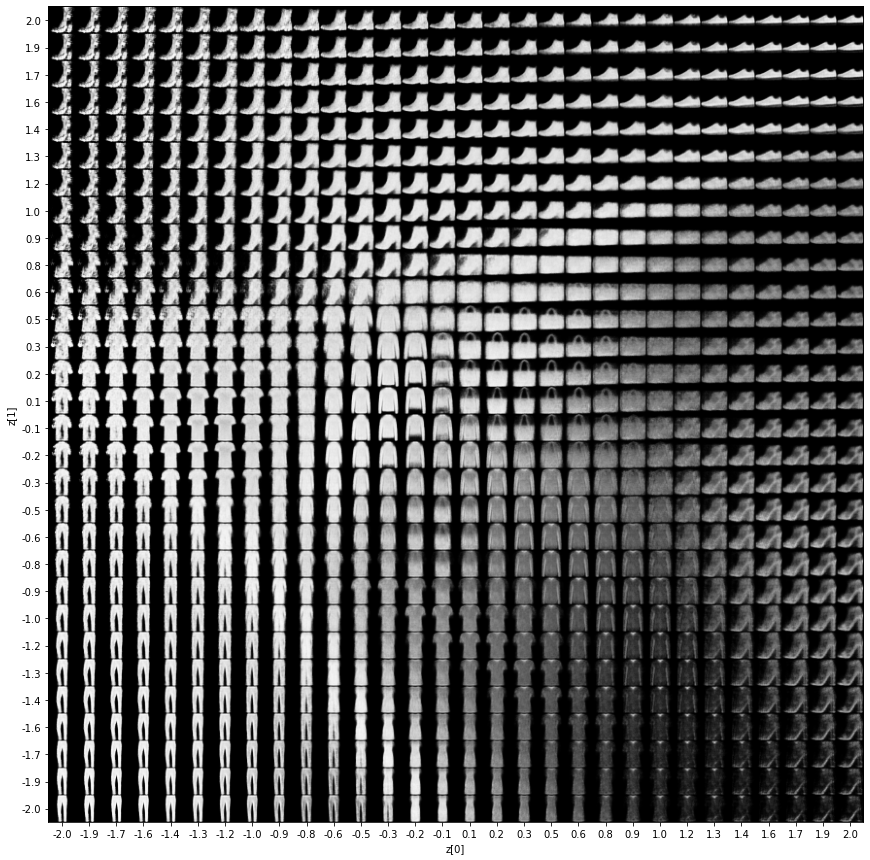

In [51]:
# Результат предсказания
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of fations
    n = 30
    f_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((f_size * n, f_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of fation classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            fation = x_decoded[0].reshape(f_size, f_size)
            figure[
                i * f_size : (i + 1) * f_size,
                j * f_size : (j + 1) * f_size,
            ] = fation

    plt.figure(figsize=(figsize, figsize))
    start_range = f_size // 2
    end_range = n * f_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, f_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

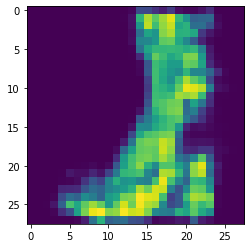

In [52]:
x_decoded = decoder.predict([[-1.990,1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

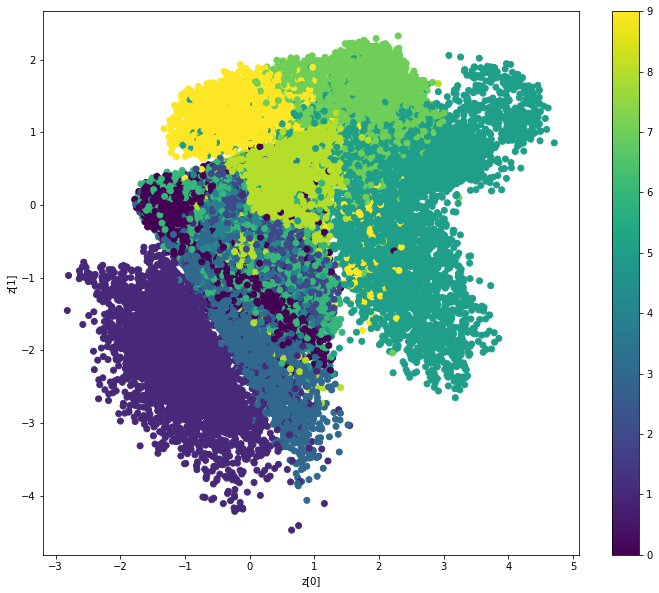

In [53]:
# Посмотрим на кластеры в скрытом пространстве
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the fation classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

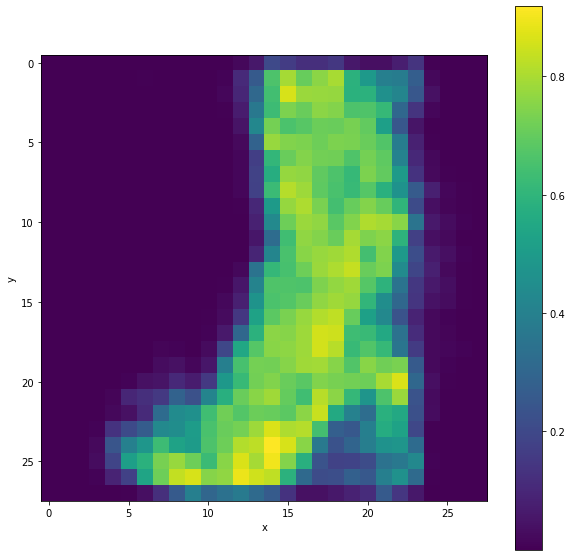

In [54]:
# Построим пример генерации
def plot_digit_from_decoder(decoder, z, f_size):
    # display a 2D plot of the fation classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    fation = decoder.predict(data)
    fation = fation.reshape(f_size, f_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(fation)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-1.5,1.], 28)

__Общие выводы:__

Точность модели росла и, соответственно, показатель "loss" падал наиболее заметно при увеличении числа эпох обучения. При уменьшении размера "batch_size" заметного эффекта не наблюдалось.

__2.    Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на 
курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?__

__DeepLab__

DeepLab - это современная система глубокого обучения для семантической сегментации изображений, построенная поверх Caffe.

Он сочетает в себе

- 1) плоскую свертку для явного управления разрешением, с которым вычисляются ответы объектов в глубоких сверточных нейронных сетях,
- 2) плоское объединение пространственных пирамид для надежной сегментации объектов в нескольких масштабах с помощью фильтров с несколькими частотами дискретизации и эффективными полями обзора,
- 3) плотно связанные условные случайные поля (CRF) в качестве последующей обработки.

DeepLab использует для своей работы atrous convolution. Этот термин взят из вейвлет-анализа и звучал как "algorithme à trous", где trous означает дыра. Еще называется dilated convolution. Фильтр умножается не на оригинальный сигнал, а на сигнал, взятый с определенным rate. Это то же самое, что использовать фильтр, прореженный нулями. Такой вид свертки позволяет получать информацию на разных масштабах изображения. "Масштаб" задается параметром rate.

![](https://drive.google.com/uc?id=13-jbar9rnlhdHcsvYlLHjnCGNVMh0cBz)
#####_Atrous convolution_

Версии DeepLab:

- DeepLabv1 2014 год - предложено использование atrous convolution;

- DeepLabv2 2016 год - atrous convolution используется в составе Atrous Spatial Pyramid Pooling, то есть параллельное использование слоев atrous convolution с разным rate - картинка внизу;

- DeepLabv3 2017 год - Atrous Spatial Pyramid Pooling объединяется с информацией уровня всего изображения - image-level feature;

![](https://drive.google.com/uc?id=1K0Zar0FkzsACb3A_5S_IBiqcKfeVTnAS)
#####_Atrous Spatial Pyramid Pooling + image-level feature_

- DeepLabv3+ 2018 год - добавляется decoder, предыдущая версия сети используется как encoder. Это позволяет лучше обрабатывать пиксели на границах объектов. В этой версии DeepLab в качестве основы используется сеть Xception и предобучение на датасете JFT-300M. Особая прелесть, что открыты исходники на TensorFlow.

- DeepLab2

Перечень задач, решаемых DeepLab2:

- семантическая сегментация (выделение точных границ объектов по классам);
- сегментация экземпляров (распознание и локализация экземпляров объектов на изображении с точностью до пикселя);
- паноптическая сегментация (объединяет две предыдущие задачи. Кроме выделения границ объектов на изображении, экземпляры каждого класса выделяются отдельно);
- оценка глубины монокулярного изображения (оценка глубины каждого пикселя);
- паноптическая сегментация видео (расширение паноптической сегментации изображения для видео. Обеспечивает идентичность распознанного экземпляра  объекта по всей видеопоследовательности);
- паноптическая сегментация видео с учетом глубины (каждый пиксель видеоряда помечен семантическим классом, распознанным экземпляром и оценочным значением глубины).

Как показатель эффективности DeepLab2, авторы приводят следующий пример. Модель Panoptic-DeepLab в составе библиотеки достигла 68,0% PQ или 83,5% mIoU при проверке на датасете "Cityscapes".
